# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = False
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 11.07 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(120910, 34)
(120910, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
  #  'lag_t1',
    'lag_t7',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:
df_merged['lag_t1'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(1))

df_merged['lag_t7'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(7))

In [9]:
x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']


x_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_pred.shape)

(89270, 27)
(89270,)
(15820, 27)
(15820,)
(15820, 27)


In [10]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=cat_features, free_raw_data=False,
                       )
validation_data = lgb.Dataset(
    x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
)

In [140]:
params = {
    'boosting_type': 'gbdt',
    #'objective': 'regression',
    'objective': 'poisson',
    #'tweedie_variance_power': 1.1,
    #'metric': 'rmse',
    'seed': 10,
    'learning_rate': 0.05,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'num_leaves': 2^11,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_mse_asymmetric_loss,
                feval=custom_rmse_asymmetric_valid
               )




c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 1.51121	valid_1's custom_mse_asymmetric_eval: 1.53768
[50]	training's custom_mse_asymmetric_eval: 1.45625	valid_1's custom_mse_asymmetric_eval: 1.50702
[75]	training's custom_mse_asymmetric_eval: 1.43861	valid_1's custom_mse_asymmetric_eval: 1.50667
Early stopping, best iteration is:
[62]	training's custom_mse_asymmetric_eval: 1.44628	valid_1's custom_mse_asymmetric_eval: 1.50536


In [97]:
# keep date here, drop later
#x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


In [141]:
def forecast_iteratively(df):
    
    # prepare df
    df['date'] = df.year.astype(str) + '-'+df.month.astype(str)+ '-'+df.day.astype(str)
    df.loc[:, 'date'] = pd.to_datetime(df['date'])
    df['y_pred'] = np.nan
    
    c = 0
    for day_i in range(28):

        date_i = (df['date'].dt.date.min() +pd.to_timedelta(day_i, unit='d'))
        date_lag1 = date_i -pd.to_timedelta(1, unit='day')
        date_lag7 = date_i -pd.to_timedelta(7, unit='day')


        df_i = df.loc[df.date == str(date_i)][features].copy()
        rel_index = df_i.index.to_list()

        """
        if str(df_i.lag_t1.values[0]) == 'nan':
            df_i['lag_t1'] = df.loc[df.date == str(date_lag1)]['lag_t1'].values
            df.loc[rel_index,['lag_t1']] = df.loc[df.date == str(date_lag1)]['lag_t1'].values

        """

        if str(df_i.lag_t7.values[0]) == 'nan':
            df_i['lag_t7'] = df.loc[df.date == str(date_lag7)]['lag_t7'].values
            df.loc[rel_index,['lag_t7']] = df.loc[df.date == str(date_lag7)]['lag_t7'].values


        y_pred_i = gbm.predict(df_i[features], num_iteration=gbm.best_iteration)
        df.loc[rel_index,['y_pred']] = y_pred_i

    return df.y_pred.values



In [142]:
y_pred = forecast_iteratively(x_pred.copy())


# Training Analysis

Plotting metrics recorded during training...


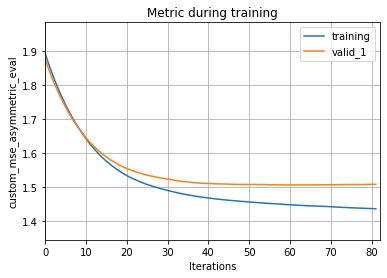

In [143]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


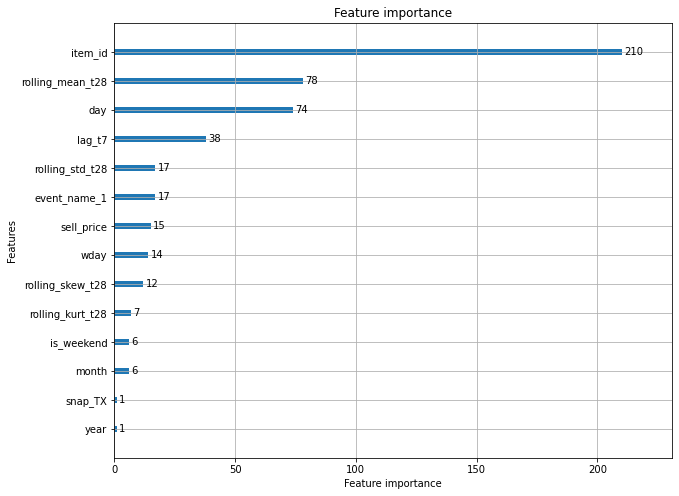

In [144]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Compute RMSSE and WRMSSE on Validation Data

In [145]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = x_val.copy()
df_tmp['y_pred'] = gbm.predict(x_val[features], num_iteration=gbm.best_iteration)
#df_tmp['y_pred'] = forecast_iteratively(x_val.copy())
df_tmp['y_true'] = y_val
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,date,y_pred,y_true,error,id
0,0,0,0,0,0,2016,3,28,0,3,...,0.533333,1.166585,0.0,0.0,0.0,2016-03-28,0.409533,0.0,-0.409533,HOBBIES_1_001_TX_2_validation
1,0,0,0,0,0,2016,3,29,0,4,...,0.466667,1.136642,0.0,0.0,0.0,2016-03-29,0.409533,0.0,-0.409533,HOBBIES_1_001_TX_2_validation
2,0,0,0,0,0,2016,3,30,0,5,...,0.466667,1.136642,0.0,0.0,0.0,2016-03-30,0.409533,0.0,-0.409533,HOBBIES_1_001_TX_2_validation
3,0,0,0,0,0,2016,3,31,0,6,...,0.466667,1.136642,0.0,0.0,0.0,2016-03-31,0.480973,1.0,0.519027,HOBBIES_1_001_TX_2_validation
4,0,0,0,0,0,2016,4,1,0,7,...,0.466667,1.136642,0.0,0.0,0.0,2016-04-01,0.409533,0.0,-0.409533,HOBBIES_1_001_TX_2_validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15815,564,1,0,0,0,2016,4,20,0,5,...,0.600000,1.003442,0.0,0.0,0.0,2016-04-20,0.503828,0.0,-0.503828,HOBBIES_2_149_TX_2_validation
15816,564,1,0,0,0,2016,4,21,0,6,...,0.600000,1.003442,0.0,0.0,0.0,2016-04-21,0.456957,0.0,-0.456957,HOBBIES_2_149_TX_2_validation
15817,564,1,0,0,0,2016,4,22,0,7,...,0.633333,0.999425,0.0,0.0,0.0,2016-04-22,0.456957,1.0,0.543043,HOBBIES_2_149_TX_2_validation
15818,564,1,0,0,0,2016,4,23,1,1,...,0.633333,0.999425,0.0,0.0,0.0,2016-04-23,0.456957,0.0,-0.456957,HOBBIES_2_149_TX_2_validation


In [146]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [131]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [147]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01172

WRMSSE = 0.01164


In [52]:
# show RMSSE and corresponding weights
rmsse_df.head(25).sort_values(by='w_times_RMSSE', ascending=False)

,RMSSE,id,weights,w_times_RMSSE
197,1.825824,HOBBIES_1_204_TX_2_validation,0.000280,0.000511
218,1.290293,HOBBIES_1_226_TX_2_validation,0.000209,0.000270
58,1.213532,HOBBIES_1_060_TX_2_validation,0.000144,0.000175
404,1.330609,HOBBIES_1_413_TX_2_validation,0.000079,0.000105
22,1.270288,HOBBIES_1_023_TX_2_validation,0.000073,0.000093
258,1.393205,HOBBIES_1_266_TX_2_validation,0.000061,0.000085
180,1.476581,HOBBIES_1_186_TX_2_validation,0.000051,0.000075
26,1.269043,HOBBIES_1_027_TX_2_validation,0.000053,0.000068
149,1.413103,HOBBIES_1_154_TX_2_validation,0.000027,0.000038
47,1.429053,HOBBIES_1_048_TX_2_validation,0.000022,0.000031


In [53]:
# analyse time series with max. RMSSE
df_tmp.loc[df_tmp.id == rmsse_df.loc[0,'id']][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
0,HOBBIES_1_001_TX_2_validation,3,28,1,13,1,0,0,0,3,8.26,0.497012,0.0,-0.497012
1,HOBBIES_1_001_TX_2_validation,3,29,1,13,1,0,0,0,4,8.26,0.421700,0.0,-0.421700
2,HOBBIES_1_001_TX_2_validation,3,30,1,13,1,0,0,0,5,8.26,0.421700,0.0,-0.421700
3,HOBBIES_1_001_TX_2_validation,3,31,1,13,1,0,0,0,6,8.26,0.449484,1.0,0.550516
4,HOBBIES_1_001_TX_2_validation,4,1,1,13,1,0,0,0,7,8.26,0.471572,0.0,-0.471572
5,HOBBIES_1_001_TX_2_validation,4,2,1,13,1,0,0,1,1,8.26,0.449484,2.0,1.550516
6,HOBBIES_1_001_TX_2_validation,4,3,1,13,1,0,0,1,2,8.26,0.300849,0.0,-0.300849
7,HOBBIES_1_001_TX_2_validation,4,4,1,13,1,0,0,0,3,8.26,0.250976,0.0,-0.250976
8,HOBBIES_1_001_TX_2_validation,4,5,1,13,1,0,0,0,4,8.26,0.300849,1.0,0.699151
9,HOBBIES_1_001_TX_2_validation,4,6,1,13,1,0,0,0,5,8.26,0.216241,0.0,-0.216241


In [54]:
# analyse time series (manually)
rel_id = 'FOODS_2_181_WI_2_validation'
df_tmp.loc[df_tmp.id == rel_id][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error


# Error for different Predicting Intervals

In [65]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = x_val.copy()
df_tmp['y_pred'] = forecast_iteratively(x_val)
df_tmp['y_true'] = y_val
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,date,y_pred,y_true,error,id
0,0,0,0,0,0,2016,3,28,0,3,...,0.533333,1.166585,0.0,0.0,0.0,2016-03-28,0.497012,0.0,-0.497012,HOBBIES_1_001_TX_2_validation
1,0,0,0,0,0,2016,3,29,0,4,...,0.466667,1.136642,0.0,0.0,0.0,2016-03-29,0.421700,0.0,-0.421700,HOBBIES_1_001_TX_2_validation
2,0,0,0,0,0,2016,3,30,0,5,...,0.466667,1.136642,0.0,0.0,0.0,2016-03-30,0.421700,0.0,-0.421700,HOBBIES_1_001_TX_2_validation
3,0,0,0,0,0,2016,3,31,0,6,...,0.466667,1.136642,0.0,0.0,0.0,2016-03-31,0.449484,1.0,0.550516,HOBBIES_1_001_TX_2_validation
4,0,0,0,0,0,2016,4,1,0,7,...,0.466667,1.136642,0.0,0.0,0.0,2016-04-01,0.471572,0.0,-0.471572,HOBBIES_1_001_TX_2_validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15815,564,1,0,0,0,2016,4,20,0,5,...,0.600000,1.003442,0.0,0.0,0.0,2016-04-20,0.437858,0.0,-0.437858,HOBBIES_2_149_TX_2_validation
15816,564,1,0,0,0,2016,4,21,0,6,...,0.600000,1.003442,0.0,0.0,0.0,2016-04-21,0.394584,0.0,-0.394584,HOBBIES_2_149_TX_2_validation
15817,564,1,0,0,0,2016,4,22,0,7,...,0.633333,0.999425,0.0,0.0,0.0,2016-04-22,0.394584,1.0,0.605416,HOBBIES_2_149_TX_2_validation
15818,564,1,0,0,0,2016,4,23,1,1,...,0.633333,0.999425,0.0,0.0,0.0,2016-04-23,0.394584,0.0,-0.394584,HOBBIES_2_149_TX_2_validation


In [66]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.00767
WRMSSE of (2016, 3, 29) = 0.00663
WRMSSE of (2016, 3, 30) = 0.00823
WRMSSE of (2016, 3, 31) = 0.00832
WRMSSE of (2016, 4, 1) = 0.00874
WRMSSE of (2016, 4, 2) = 0.01033
WRMSSE of (2016, 4, 3) = 0.00911
WRMSSE of (2016, 4, 4) = 0.01062
WRMSSE of (2016, 4, 5) = 0.00917
WRMSSE of (2016, 4, 6) = 0.00677
WRMSSE of (2016, 4, 7) = 0.00871
WRMSSE of (2016, 4, 8) = 0.00914
WRMSSE of (2016, 4, 9) = 0.01057
WRMSSE of (2016, 4, 10) = 0.01058
WRMSSE of (2016, 4, 11) = 0.00889
WRMSSE of (2016, 4, 12) = 0.01055
WRMSSE of (2016, 4, 13) = 0.00825
WRMSSE of (2016, 4, 14) = 0.00822
WRMSSE of (2016, 4, 15) = 0.00885
WRMSSE of (2016, 4, 16) = 0.01099
WRMSSE of (2016, 4, 17) = 0.01102
WRMSSE of (2016, 4, 18) = 0.00708
WRMSSE of (2016, 4, 19) = 0.00957
WRMSSE of (2016, 4, 20) = 0.01134
WRMSSE of (2016, 4, 21) = 0.00967
WRMSSE of (2016, 4, 22) = 0.00858
WRMSSE of (2016, 4, 23) = 0.01100
WRMSSE of (2016, 4, 24) = 0.00860


# Printout Forecasts

In [26]:
# map forecast values to encoded item_ids
x_pred['y_pred'] = y_pred

In [27]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,sell_price,lag_t7,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
105090,0,0,0,0,0,2016,4,25,0,3,...,8.26,0.0,8.085505,2.942952,0.266667,0.691492,0.0,0.0,0.0,0.250976
105091,1,0,0,0,0,2016,4,25,0,3,...,3.97,2.0,28.000000,5.477226,0.033333,0.182574,0.0,0.0,0.0,0.213398
105092,2,0,0,0,0,2016,4,25,0,3,...,2.97,0.0,28.000000,5.477226,0.033333,0.182574,0.0,0.0,0.0,0.185469
105093,3,0,0,0,0,2016,4,25,0,3,...,4.64,2.0,0.815230,1.051023,1.100000,1.322224,0.0,0.0,0.0,1.245555
105094,4,0,0,0,0,2016,4,25,0,3,...,2.73,0.0,6.833795,2.557249,0.600000,1.132589,0.0,0.0,0.0,0.632647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120905,560,1,0,0,0,2016,5,22,1,2,...,2.88,NaN,11.497869,3.494974,0.133333,0.434172,0.0,0.0,0.0,0.185469
120906,561,1,0,0,0,2016,5,22,1,2,...,1.97,NaN,3.233676,2.147972,0.266667,0.583292,0.0,0.0,0.0,0.278760
120907,562,1,0,0,0,2016,5,22,1,2,...,0.97,NaN,6.534278,2.387013,0.700000,1.118805,0.0,0.0,0.0,0.457831
120908,563,1,0,0,0,2016,5,22,1,2,...,0.88,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.0,0.185469


In [28]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [29]:
id_mapping_table

,id,item_id,year,month,day,store_id
0,HOBBIES_1_001_TX_2_validation,0,2015,10,22,0
1,HOBBIES_1_002_TX_2_validation,1,2015,10,22,0
2,HOBBIES_1_003_TX_2_validation,2,2015,10,22,0
3,HOBBIES_1_004_TX_2_validation,3,2015,10,22,0
4,HOBBIES_1_005_TX_2_validation,4,2015,10,22,0
...,...,...,...,...,...,...
120905,HOBBIES_2_145_TX_2_validation,560,2016,5,22,0
120906,HOBBIES_2_146_TX_2_validation,561,2016,5,22,0
120907,HOBBIES_2_147_TX_2_validation,562,2016,5,22,0
120908,HOBBIES_2_148_TX_2_validation,563,2016,5,22,0


In [30]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [31]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.250976,0.250976,0.278760,0.363915,0.314043,0.349136,0.399008,0.399008,0.399008,...,0.399008,0.349136,0.349136,0.349136,0.349136,0.449484,0.421700,0.471572,0.314043,0.363915
1,HOBBIES_1_002_TX_2_validation,0.213398,0.185469,0.213398,0.185469,0.185469,0.185469,0.213398,0.213398,0.185469,...,0.185469,0.185469,0.213398,0.213398,0.185469,0.213398,0.185469,0.185469,0.185469,0.228679
2,HOBBIES_1_003_TX_2_validation,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,...,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469
3,HOBBIES_1_004_TX_2_validation,1.245555,1.245555,1.231959,1.245555,1.267831,1.243600,1.245555,1.245555,1.245555,...,1.267831,1.189594,1.245555,1.245555,1.299561,1.233913,1.299561,1.157863,1.189594,1.299561
4,HOBBIES_1_005_TX_2_validation,0.632647,0.632647,0.632647,0.632647,0.632647,0.731773,0.632647,0.632647,0.632647,...,0.632647,0.731773,0.632647,0.632647,0.632647,0.632647,0.452671,0.452671,0.633769,0.452671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,HOBBIES_2_145_TX_2_validation,0.296580,0.261487,0.261487,0.261487,0.261487,0.304761,0.261487,0.261487,0.261487,...,0.185469,0.213398,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.213398,0.185469
561,HOBBIES_2_146_TX_2_validation,0.296580,0.261487,0.261487,0.339854,0.339854,0.296580,0.412418,0.369144,0.296580,...,0.228679,0.200751,0.228679,0.200751,0.200751,0.200751,0.213398,0.228679,0.200751,0.278760
562,HOBBIES_2_147_TX_2_validation,0.394584,0.394584,0.394584,0.394584,0.437858,0.437858,0.457831,0.394584,0.457831,...,0.631430,0.631430,0.588156,0.588156,0.588156,0.457831,0.457831,0.631430,0.631430,0.457831
563,HOBBIES_2_148_TX_2_validation,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,...,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469


# Increase Predictions for Food Items as they are underestimated

In [32]:
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

In [33]:
submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_TX_2_validation,0.250976,0.250976,0.278760,0.363915,0.314043,0.349136,0.399008,0.399008,0.399008,...,0.399008,0.349136,0.349136,0.349136,0.349136,0.449484,0.421700,0.471572,0.314043,0.363915
1,HOBBIES_1_002_TX_2_validation,0.213398,0.185469,0.213398,0.185469,0.185469,0.185469,0.213398,0.213398,0.185469,...,0.185469,0.185469,0.213398,0.213398,0.185469,0.213398,0.185469,0.185469,0.185469,0.228679
2,HOBBIES_1_003_TX_2_validation,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,...,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469
3,HOBBIES_1_004_TX_2_validation,1.245555,1.245555,1.231959,1.245555,1.267831,1.243600,1.245555,1.245555,1.245555,...,1.267831,1.189594,1.245555,1.245555,1.299561,1.233913,1.299561,1.157863,1.189594,1.299561
4,HOBBIES_1_005_TX_2_validation,0.632647,0.632647,0.632647,0.632647,0.632647,0.731773,0.632647,0.632647,0.632647,...,0.632647,0.731773,0.632647,0.632647,0.632647,0.632647,0.452671,0.452671,0.633769,0.452671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,HOBBIES_2_145_TX_2_validation,0.296580,0.261487,0.261487,0.261487,0.261487,0.304761,0.261487,0.261487,0.261487,...,0.185469,0.213398,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.213398,0.185469
561,HOBBIES_2_146_TX_2_validation,0.296580,0.261487,0.261487,0.339854,0.339854,0.296580,0.412418,0.369144,0.296580,...,0.228679,0.200751,0.228679,0.200751,0.200751,0.200751,0.213398,0.228679,0.200751,0.278760
562,HOBBIES_2_147_TX_2_validation,0.394584,0.394584,0.394584,0.394584,0.437858,0.437858,0.457831,0.394584,0.457831,...,0.631430,0.631430,0.588156,0.588156,0.588156,0.457831,0.457831,0.631430,0.631430,0.457831
563,HOBBIES_2_148_TX_2_validation,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,...,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469,0.185469


# Submit to Kaggle 

In [34]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/gradient_boosting_regressor_v_2_5.csv -m "asymetric loss with factor 1.1 if res > 1"


In [35]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation', value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)